In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import pandas as pd

# ==== 0) Parâmetros ====
ARQ_IN    = "Matrix.csv"        # saída do passo anterior (pivot pronto)
OUT_W     = "W_frames.csv"      # pesos por frame (frames × K)
OUT_H     = "H_padroes.csv"     # padrões (K × células)
OUT_TOP   = "frames_tipicos_CNN_KMEANS.csv"
SEED      = 42
MAX_ITER  = 2000

# Ler a matriz W gerada pelo NMF (output do passo anterior)
df_W = pd.read_csv("nmf_W_TS.csv", index_col=0)

print(f"✅ df_W carregado: {df_W.shape[0]} frames × {df_W.shape[1]} padrões")
df_W.head()


✅ df_W carregado: 850 frames × 16 padrões


,padrao_1,padrao_2,padrao_3,padrao_4,padrao_5,padrao_6,padrao_7,padrao_8,padrao_9,padrao_10,padrao_11,padrao_12,padrao_13,padrao_14,padrao_15,padrao_16
timestamp,,,,,,,,,,,,,,,,
1900-01-01 00:00:00.852,0.000000,0.000000e+00,9.431295e-155,4.226021e-83,1.195915e-46,0.000000,4.593524e-101,4.508182e-78,2.806507e-59,1.863434e+00,1.012762e+00,1.009208e-81,1.281967e-36,3.629010e-117,1.750227e-20,0.00000
1900-01-01 00:00:03.401,0.262673,0.000000e+00,5.756467e-252,1.953594e-82,5.694325e-19,0.599497,2.788895e-51,2.802952e-20,3.734614e-61,1.502444e-220,5.382139e-69,0.000000e+00,2.958861e-01,2.446862e-78,1.687845e+00,0.00000
1900-01-01 00:00:07.974,0.000000,0.000000e+00,1.308255e+00,0.000000e+00,1.138317e-271,0.000000,4.752867e-57,3.591706e-76,0.000000e+00,2.669327e-01,4.382321e-115,0.000000e+00,1.575743e-82,1.414540e-143,0.000000e+00,0.00000
1900-01-01 00:00:08.614,0.000000,1.649873e-47,0.000000e+00,6.107327e-01,0.000000e+00,0.002216,0.000000e+00,1.455044e-79,2.497476e-01,0.000000e+00,0.000000e+00,4.036409e-01,2.688885e-23,2.562473e-01,0.000000e+00,0.74553
1900-01-01 00:00:09.458,0.000000,0.000000e+00,1.468883e+00,6.498513e-184,9.167106e-90,0.000000,1.319310e-48,0.000000e+00,0.000000e+00,5.520660e-58,0.000000e+00,1.458454e-129,0.000000e+00,0.000000e+00,3.110900e-14,0.00000


In [3]:
# Normalizar W para [0,1] (necessário porque o decoder termina em Sigmoid)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_W)

# Redimensionar para formato (frames, canais, padrões)
X_scaled = np.expand_dims(X_scaled, axis=1)

# Converter em tensor PyTorch
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


# Autoencoder → input = output
dataset = TensorDataset(X_tensor, X_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

print("Dados normalizados e loader pronto:", X_tensor.shape)

Dados normalizados e loader pronto: torch.Size([850, 1, 16])


In [4]:
# === Definir CNN Autoencoder robusta ===
import torch.nn as nn

class CNNAutoencoder(nn.Module):
    def __init__(self, input_len=10, embedding_dim=64):
        super(CNNAutoencoder, self).__init__()
        
        # ----- ENCODER -----
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.AdaptiveAvgPool1d(1)   # condensa cada filtro num valor
        )
        self.fc_enc = nn.Linear(128, embedding_dim)   # embedding final

        # ----- DECODER -----
        self.fc_dec = nn.Linear(embedding_dim, 128)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.ConvTranspose1d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()  # saída [0,1]
        )
        
    def forward(self, x):
        # Encoder
        x = self.encoder(x)            
        x = x.view(x.size(0), -1)     
        z = self.fc_enc(x)            # embeddings
        
        # Decoder
        x = self.fc_dec(z)            
        x = x.view(x.size(0), 128, 1) 
        x = self.decoder(x)           
        return z, x

# Instanciar modelo
embedding_dim = 64
model = CNNAutoencoder(input_len=10, embedding_dim=embedding_dim)


In [5]:
# === Treino com Early Stopping ===
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 200
patience = 15
best_loss = float("inf")
trigger = 0

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for X_batch, _ in loader:
        optimizer.zero_grad()
        z, X_recon = model(X_batch)
        loss = criterion(X_recon, X_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(loader)
    print(f"Época {epoch+1}/{EPOCHS}, Loss médio={avg_loss:.6f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("⏹ Early stopping ativado!")
            break


/Users/rr/.pyenv/versions/3.11.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([32, 1, 16])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rr/.pyenv/versions/3.11.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([18, 1, 16])) that is different to the input size (torch.Size([18, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Época 1/200, Loss médio=0.128948
Época 2/200, Loss médio=0.058053
Época 3/200, Loss médio=0.035641
Época 4/200, Loss médio=0.028202
Época 5/200, Loss médio=0.025083
Época 6/200, Loss médio=0.023149
Época 7/200, Loss médio=0.022440
Época 8/200, Loss médio=0.021630
Época 9/200, Loss médio=0.021190
Época 10/200, Loss médio=0.020911
Época 11/200, Loss médio=0.020711
Época 12/200, Loss médio=0.020525
Época 13/200, Loss médio=0.020544
Época 14/200, Loss médio=0.020448
Época 15/200, Loss médio=0.020370
Época 16/200, Loss médio=0.020319
Época 17/200, Loss médio=0.020376
Época 18/200, Loss médio=0.020309
Época 19/200, Loss médio=0.020269
Época 20/200, Loss médio=0.020152
Época 21/200, Loss médio=0.020253
Época 22/200, Loss médio=0.020259
Época 23/200, Loss médio=0.020162
Época 24/200, Loss médio=0.020250
Época 25/200, Loss médio=0.020252
Época 26/200, Loss médio=0.020145
Época 27/200, Loss médio=0.020270
Época 28/200, Loss médio=0.020281
Época 29/200, Loss médio=0.020220
Época 30/200, Loss médi

In [6]:
# === Extrair embeddings ===
embeddings = []
with torch.no_grad():
    for X_batch, _ in loader:
        z, _ = model(X_batch)    # z = embedding
        embeddings.append(z.numpy())

embeddings = np.vstack(embeddings)
print("Embeddings shape:", embeddings.shape)


Embeddings shape: (850, 64)


In [7]:
embeddings

array([[ 0.20669349,  0.0862808 , -0.04859893, ..., -0.23119316,
        -0.16007635, -0.3103179 ],
       [ 0.5440093 ,  0.20527798, -0.29582372, ..., -0.40542427,
        -0.28417176, -0.66911495],
       [ 0.62946707,  0.08744856,  0.00622703, ..., -0.56505734,
        -0.33137935, -0.968063  ],
       ...,
       [ 0.5564571 ,  0.4417582 , -0.5102016 , ..., -0.5965162 ,
        -0.6178414 , -0.79262877],
       [ 0.30971658,  0.01596898, -0.01995141, ..., -0.4003027 ,
        -0.25394338, -0.5936843 ],
       [ 0.5939798 ,  0.15549716, -0.40507355, ..., -0.5518367 ,
        -0.29005742, -0.7509723 ]], shape=(850, 64), dtype=float32)

Shape dos embeddings: (850, 64)
➡️ Nº de clusters escolhido pelo cotovelo da inércia: 3


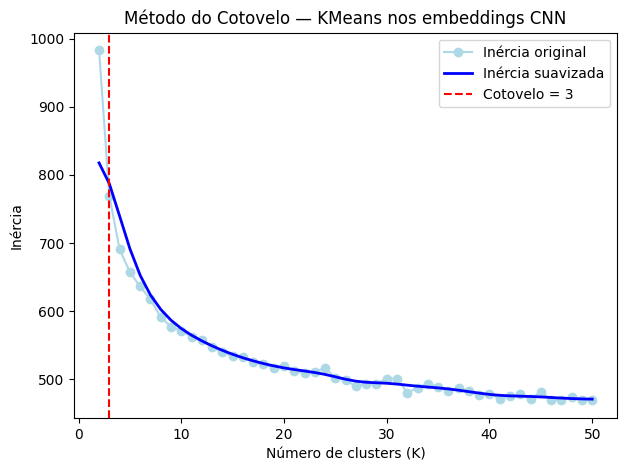

In [8]:
# ==============================================
# Clustering com MiniBatchKMeans — apenas inércia
# ==============================================
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ---- Garantir que tens os embeddings ----
print("Shape dos embeddings:", embeddings.shape)

# ---- Definir intervalo de K ----
max_k = min(50, embeddings.shape[0])   # não pode ultrapassar nº de frames
Ks, inertias = [], []

# ---- Loop de clustering ----
for k in range(2, max_k+1):
    km = MiniBatchKMeans(
        n_clusters=k,
        random_state=SEED,
        batch_size=128,
        n_init=10
    )
    km.fit(embeddings)
    Ks.append(k)
    inertias.append(km.inertia_)

# ---- Converter listas para arrays ----
inertias = np.array(inertias)

# ---- Suavizar curva da inércia ----
inertias_smooth = gaussian_filter1d(inertias, sigma=2)

# ---- Critério do cotovelo (queda relativa) ----
drops = np.r_[np.nan, -(np.diff(inertias_smooth))]
rel = drops / np.r_[np.nan, inertias_smooth[:-1]]
limite = 0.05  # 5%
idx = np.where(rel < limite)[0]
K_cotovelo = Ks[idx[0]] if len(idx) else Ks[np.argmin(inertias_smooth)]

print(f"➡️ Nº de clusters escolhido pelo cotovelo da inércia: {K_cotovelo}")

# ---- Cluster final ----
kmeans_final = MiniBatchKMeans(
    n_clusters=K_cotovelo,
    random_state=SEED,
    batch_size=128,
    n_init=10
)
labels_final = kmeans_final.fit_predict(embeddings)

df_clusters = pd.DataFrame({
    "timestamp": df_W.index,
    "cluster": labels_final
})

# ---- Gráfico da inércia ----
plt.figure(figsize=(7,5))
plt.plot(Ks, inertias, marker="o", color="lightblue", label="Inércia original")
plt.plot(Ks, inertias_smooth, color="blue", linewidth=2, label="Inércia suavizada")
plt.axvline(K_cotovelo, color="red", linestyle="--", label=f"Cotovelo = {K_cotovelo}")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inércia")
plt.title("Método do Cotovelo — KMeans nos embeddings CNN")
plt.legend()
plt.grid(False)
plt.show()


In [9]:
# ==== Aplicar K-Means final em W (usando K do cotovelo) ====
kmeans = MiniBatchKMeans(
    n_clusters=K_cotovelo,
    random_state=SEED,
    batch_size=128,
    n_init=10
)
labels = kmeans.fit_predict(embeddings)


df_clusters = df_W.copy()
df_clusters["cluster"] = labels
df_clusters["timestamp"] = df_W.index

print("Clusters atribuídos:")
display(df_clusters)

print("\nDistribuição por cluster:")
print(df_clusters["cluster"].value_counts())


Clusters atribuídos:


,padrao_1,padrao_2,padrao_3,padrao_4,padrao_5,padrao_6,padrao_7,padrao_8,padrao_9,padrao_10,padrao_11,padrao_12,padrao_13,padrao_14,padrao_15,padrao_16,cluster,timestamp
timestamp,,,,,,,,,,,,,,,,,,
1900-01-01 00:00:00.852,0.000000e+00,0.000000e+00,9.431295e-155,4.226021e-83,1.195915e-46,0.000000e+00,4.593524e-101,4.508182e-78,2.806507e-59,1.863434e+00,1.012762e+00,1.009208e-81,1.281967e-36,3.629010e-117,1.750227e-20,0.000000,2,1900-01-01 00:00:00.852
1900-01-01 00:00:03.401,2.626727e-01,0.000000e+00,5.756467e-252,1.953594e-82,5.694325e-19,5.994969e-01,2.788895e-51,2.802952e-20,3.734614e-61,1.502444e-220,5.382139e-69,0.000000e+00,2.958861e-01,2.446862e-78,1.687845e+00,0.000000,0,1900-01-01 00:00:03.401
1900-01-01 00:00:07.974,0.000000e+00,0.000000e+00,1.308255e+00,0.000000e+00,1.138317e-271,0.000000e+00,4.752867e-57,3.591706e-76,0.000000e+00,2.669327e-01,4.382321e-115,0.000000e+00,1.575743e-82,1.414540e-143,0.000000e+00,0.000000,1,1900-01-01 00:00:07.974
1900-01-01 00:00:08.614,0.000000e+00,1.649873e-47,0.000000e+00,6.107327e-01,0.000000e+00,2.215747e-03,0.000000e+00,1.455044e-79,2.497476e-01,0.000000e+00,0.000000e+00,4.036409e-01,2.688885e-23,2.562473e-01,0.000000e+00,0.745530,2,1900-01-01 00:00:08.614
1900-01-01 00:00:09.458,0.000000e+00,0.000000e+00,1.468883e+00,6.498513e-184,9.167106e-90,0.000000e+00,1.319310e-48,0.000000e+00,0.000000e+00,5.520660e-58,0.000000e+00,1.458454e-129,0.000000e+00,0.000000e+00,3.110900e-14,0.000000,1,1900-01-01 00:00:09.458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900-01-01 00:48:50.491,0.000000e+00,5.472457e-01,0.000000e+00,5.363596e-66,1.492535e-53,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.706059,0,1900-01-01 00:48:50.491
1900-01-01 00:48:52.648,0.000000e+00,3.277769e-23,0.000000e+00,0.000000e+00,0.000000e+00,3.045685e-75,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.545797,2,1900-01-01 00:48:52.648
1900-01-01 00:49:02.726,6.340757e-262,1.153497e+00,0.000000e+00,0.000000e+00,4.095998e-53,2.500271e-206,0.000000e+00,0.000000e+00,3.857211e-01,1.337137e-126,0.000000e+00,0.000000e+00,0.000000e+00,7.997065e-136,6.531054e-09,0.370757,1,1900-01-01 00:49:02.726



Distribuição por cluster:
cluster
2    337
0    330
1    183
Name: count, dtype: int64


In [10]:
from sklearn.metrics import pairwise_distances_argmin_min

# índices dos medoids (mais próximos dos centros dos clusters)
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, embeddings)

# marcar medoids
df_clusters["is_medoid"] = False
df_clusters.iloc[closest, df_clusters.columns.get_loc("is_medoid")] = True

# mostrar resultados
medoids = df_clusters[df_clusters["is_medoid"]][["timestamp", "cluster"]]
print("Timestamps mais representativos (medoids):")
display(medoids)


Timestamps mais representativos (medoids):


,timestamp,cluster
timestamp,,
1900-01-01 00:02:49.679,1900-01-01 00:02:49.679,2
1900-01-01 00:12:15.542,1900-01-01 00:12:15.542,1
1900-01-01 00:13:26.884,1900-01-01 00:13:26.884,0


In [11]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ==== Métricas de clusterização ====
X_features = embeddings               # usa embeddings do Autoencoder CNN
labels = df_clusters["cluster"].values  

silhouette = silhouette_score(X_features, labels)        # [-1, 1]; >0.3 já é razoável
davies     = davies_bouldin_score(X_features, labels)   # menor é melhor (~1 bom)
calinski   = calinski_harabasz_score(X_features, labels) # maior é melhor

print("📊 Métricas de clusterização (KMeans em embeddings CNN)")
print(f"Silhouette Score:        {silhouette:.4f}")
print(f"Davies-Bouldin Index:    {davies:.4f}")
print(f"Calinski-Harabasz Index: {calinski:.4f}")


📊 Métricas de clusterização (KMeans em embeddings CNN)
Silhouette Score:        0.2692
Davies-Bouldin Index:    1.2593
Calinski-Harabasz Index: 595.1903


In [12]:
# ==== Exportar frames típicos (medoids) ====
medoids = df_clusters.loc[df_clusters["is_medoid"], ["timestamp", "cluster"]]

medoids.to_csv(OUT_TOP, index=False)

print("Frames típicos (medoids) exportados para:", OUT_TOP)
display(medoids)


Frames típicos (medoids) exportados para: frames_tipicos_CNN_KMEANS.csv


,timestamp,cluster
timestamp,,
1900-01-01 00:02:49.679,1900-01-01 00:02:49.679,2
1900-01-01 00:12:15.542,1900-01-01 00:12:15.542,1
1900-01-01 00:13:26.884,1900-01-01 00:13:26.884,0
